In [2]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import random

In [3]:
train_dir = r'brain-tumor-mri-dataset/Training'
test_dir = 'brain-tumor-mri-dataset/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

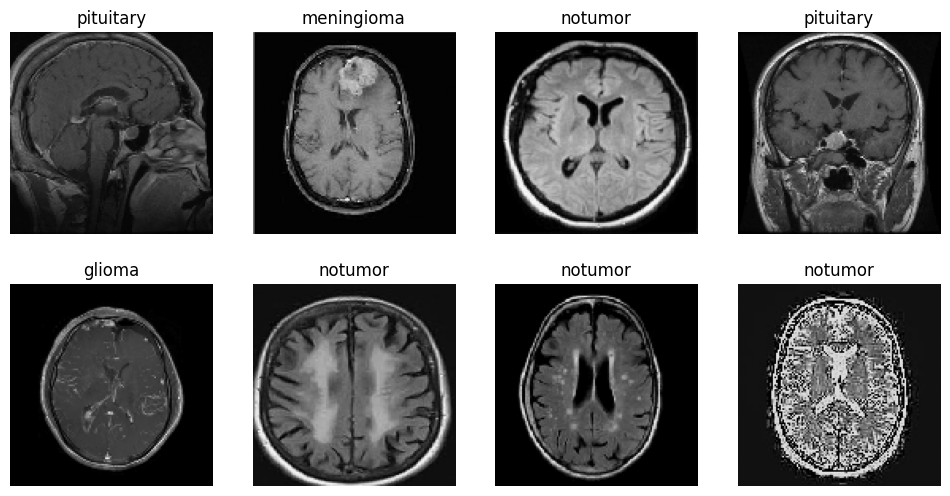

In [5]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [6]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [7]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                4

In [8]:
model.fit(datagen(train_paths, train_labels, batch_size=32, epochs=10), steps_per_epoch=len(train_paths)//32, epochs=10)

Epoch 1/10
178/178 [==============================] - 19s 91ms/step - loss: 0.7365 - accuracy: 0.6972
Epoch 2/10
178/178 [==============================] - 17s 91ms/step - loss: 0.4432 - accuracy: 0.8319
Epoch 3/10
178/178 [==============================] - 16s 91ms/step - loss: 0.2978 - accuracy: 0.8873
Epoch 4/10
178/178 [==============================] - 16s 91ms/step - loss: 0.2073 - accuracy: 0.9236
Epoch 5/10
178/178 [==============================] - 16s 90ms/step - loss: 0.1589 - accuracy: 0.9428
Epoch 6/10
178/178 [==============================] - 17s 94ms/step - loss: 0.1225 - accuracy: 0.9544
Epoch 7/10
178/178 [==============================] - 16s 91ms/step - loss: 0.0926 - accuracy: 0.9685
Epoch 8/10
178/178 [==============================] - 16s 92ms/step - loss: 0.0713 - accuracy: 0.9743
Epoch 9/10
178/178 [==============================] - 17s 92ms/step - loss: 0.0463 - accuracy: 0.9854
Epoch 10/10
178/178 [==============================] - 16s 91ms/step - loss: 0.028

In [9]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [10]:
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

41/41 [==============================] - 1s 13ms/step - loss: 0.3377 - accuracy: 0.9314
Train accuracy: 0.9786414504051208
Test accuracy: 0.9313501119613647


In [11]:
predictions = model.predict(open_images(test_paths))
predictions = np.argmax(predictions, axis=1)
print(classification_report(encode_label(test_labels), predictions, target_names=unique_labels))

              precision    recall  f1-score   support

      glioma       0.98      0.75      0.85       300
  meningioma       0.81      0.96      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



In [12]:
base_model = InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

87924736/87910968 [==============================] - 46s 1us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
______________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 8
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/8
285/285 [==============================] - 25s 61ms/step - loss: 0.8806 - accuracy: 0.6549
Epoch 2/8
285/285 [==============================] - 19s 61ms/step - loss: 0.5466 - accuracy: 0.7967
Epoch 3/8
285/285 [==============================] - 17s 61ms/step - loss: 0.4566 - accuracy: 0.8289
Epoch 4/8
285/285 [==============================] - 18s 63ms/step - loss: 0.4067 - accuracy: 0.8440
Epoch 5/8
285/285 [==============================] - 18s 62ms/step - loss: 0.3657 - accuracy: 0.8631
Epoch 6/8
285/285 [==============================] - 18s 63ms/step - loss: 0.3234 - accuracy: 0.8774
Epoch 7/8
285/285 [==============================] - 18s 64ms/step - loss: 0.2884 - accuracy: 0.8930
Epoch 8/8
285/285 [==============================] - 18s 65ms/step - loss: 0.2805 - accuracy: 0.8949


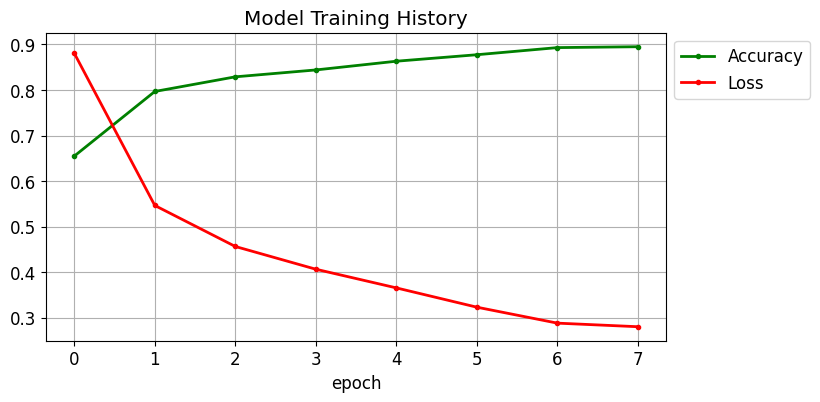

In [14]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [15]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

41it [00:14,  2.74it/s]                                                                                                


In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.88      0.84      0.86       300
  meningioma       0.82      0.77      0.80       306
     notumor       0.96      0.97      0.97       405
   pituitary       0.88      0.96      0.91       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.89      0.89      0.89      1311

